In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import time
from sklearn.metrics import mean_squared_error,roc_auc_score,mean_absolute_error,log_loss
import sys
sys.path.append('benchmark/')
from gammli_test import gammli
from xgb_test import xgb
from svd_test import svd
from deepfm_fm_test import deepfm_fm
from rank_test import rtest
sys.path.append('../')
from gammli.GAMMLI import GAMMLI
from gammli.DataReader import data_initialize
from gammli.utils import local_visualize
from gammli.utils import global_visualize_density
from gammli.utils import feature_importance_visualize
from gammli.utils import plot_trajectory
from gammli.utils import plot_regularization
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
random_state=0
data= pd.read_csv('data/santander/Santander.csv')

task_type = "Classification"

list1 = data.columns
meta_info = OrderedDict()
for i in list1:
    meta_info[i]={'type': 'categorical','source':'user'}
meta_info['income']={"type":"continues",'source':'user'}
meta_info['cust_seniority']={"type":"continues",'source':'user'}
meta_info['age'] = {"type":"continues",'source':'user'}
meta_info['item'] = {'type': 'categorical','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
#the best shrinkage is 0.840000
#the best combination is 0.613360
lx_params = {
        "rank":3,
        "main_effect_epochs":30,
        "interaction_epochs" : 30 ,
        "tuning_epochs" : 10 , 
        "mf_training_iters": 50,
        "u_group_num": 50,
        "i_group_num":20,
        "best_shrinkage":1,
        "best_combination":0.4,
        "auto_tune":False,
        "verbose":True
    }

deepfm_fm_params = {
        "epochs":20,
        "loss_type" : 'logloss' ,
        "eval_metric" : log_loss , 
        "greater_is_better": False,
        "verbose":True,
        "early_stopping": True
    }

W0808 15:04:19.511847 11044 deprecation.py:323] From C:\Users\64161\Anaconda3\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
result_gammli = gammli('warm',data, meta_info,task_type , random_state=0, params=lx_params)
result_svd = svd('warm',data, meta_info, task_type , random_state=0)
result_deepfm, result_fm = deepfm_fm('warm',data, meta_info,task_type , random_state=0, params=deepfm_fm_params)
result_xgb = xgb('warm',data, meta_info, task_type , random_state=0)

result_sim_std = pd.concat([result_gammli,result_svd,result_xgb,result_deepfm,result_fm],0)

result_sim_std.to_csv('santander_result.csv',index=None)

## explanation

In [2]:
data= pd.read_csv('data/santander/Santander.csv')

task_type = "Classification"

list1 = data.columns
meta_info = OrderedDict()
for i in list1:
    meta_info[i]={'type': 'categorical','source':'user'}
meta_info['income']={"type":"continues",'source':'user'}
meta_info['cust_seniority']={"type":"continues",'source':'user'}
meta_info['age'] = {"type":"continues",'source':'user'}
meta_info['item'] = {'type': 'categorical','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
train , test = train_test_split(data,test_size=0.2 ,random_state=0)
tr_x, tr_Xi, tr_y, tr_idx, te_x, te_Xi, te_y, val_x, val_Xi, val_y, val_idx, meta_info, model_info ,sy,sy_t= data_initialize(train,test,meta_info,task_type ,'warm', 0, True)

model = GAMMLI(wc='warm',model_info=model_info, meta_info=meta_info, subnet_arch=[8, 16],interact_arch=[20, 10],activation_func=tf.tanh, batch_size=1000, lr_bp=0.01, auto_tune=False,
               interaction_epochs=20,main_effect_epochs=30,tuning_epochs=10,loss_threshold_main=0.01,loss_threshold_inter=0.01,combine_range=0.95,
              verbose=True, early_stop_thres=100,interact_num=10,u_group_num=50,i_group_num=10,scale_ratio=0.978,n_power_iterations=5,n_oversamples=0,
              mf_training_iters=50,change_mode=True,convergence_threshold=0.001,max_rank=3,shrinkage_value=20, interaction_restrict='inter')
model.fit(tr_x, val_x, tr_y, val_y, tr_Xi, val_Xi, tr_idx, val_idx)

..\gammli\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\gammli\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\gammli\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(n

Memory usage of dataframe is 52.20 MB
Memory usage after optimization is: 11.27 MB
Decreased by 78.4%
Memory usage of dataframe is 13.05 MB
Memory usage after optimization is: 2.82 MB
Decreased by 78.4%
test cold start user: 14
test cold start item: 0
validation cold start user: 11
validation cold start item: 0
ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.08068, val loss: 0.08034
Main effects training epoch: 2, train loss: 0.07822, val loss: 0.07789
Main effects training epoch: 3, train loss: 0.07770, val loss: 0.07751
Main effects training epoch: 4, train loss: 0.07739, val loss: 0.07717
Main effects training epoch: 5,

C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[SoftImpute] Iter 1: observed BCE=0.015861 validation BCE=0.059220,rank=3
[SoftImpute] Iter 2: observed BCE=0.011553 validation BCE=0.056660,rank=3
[SoftImpute] Iter 3: observed BCE=0.009241 validation BCE=0.056406,rank=3
[SoftImpute] Iter 4: observed BCE=0.007895 validation BCE=0.056517,rank=3
[SoftImpute] Iter 5: observed BCE=0.007086 validation BCE=0.056590,rank=3
[SoftImpute] Iter 6: observed BCE=0.006606 validation BCE=0.056563,rank=3
[SoftImpute] Iter 7: observed BCE=0.006307 validation BCE=0.056441,rank=3
[SoftImpute] Iter 8: observed BCE=0.006110 validation BCE=0.056072,rank=3
[SoftImpute] Iter 9: observed BCE=0.005966 validation BCE=0.055662,rank=3
[SoftImpute] Iter 10: observed BCE=0.005856 validation BCE=0.055276,rank=3
[SoftImpute] Iter 11: observed BCE=0.005772 validation BCE=0.054895,rank=3
[SoftImpute] Iter 12: observed BCE=0.005705 validation BCE=0.054524,rank=3
[SoftImpute] Iter 13: observed BCE=0.005650 validation BCE=0.054185,rank=3
[SoftImpute] Iter 14: observed BCE

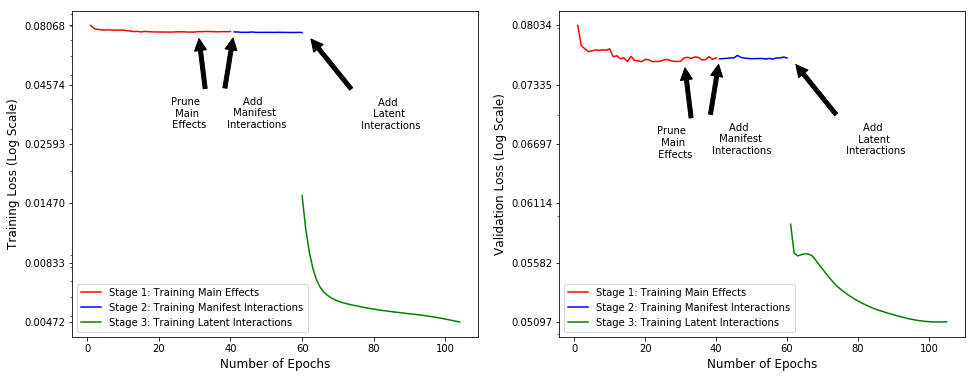

In [3]:
simu_dir = 'result'
data_dict_logs = model.final_gam_model.summary_logs(save_dict=False)
data_dict_logs.update({"err_train_mf":model.final_mf_model.mf_mae,
                       "err_val_mf":model.final_mf_model.mf_valmae})
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=False, save_eps=True)
#plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=False, save_eps=False)

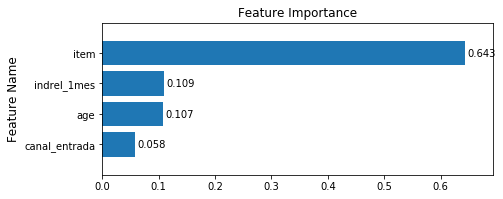

In [4]:
data_dict = model.final_gam_model.global_explain(0,save_dict=False,threshold=0.05)
feature_importance_visualize(data_dict, save_eps=True, folder=simu_dir, name='s1_feature')

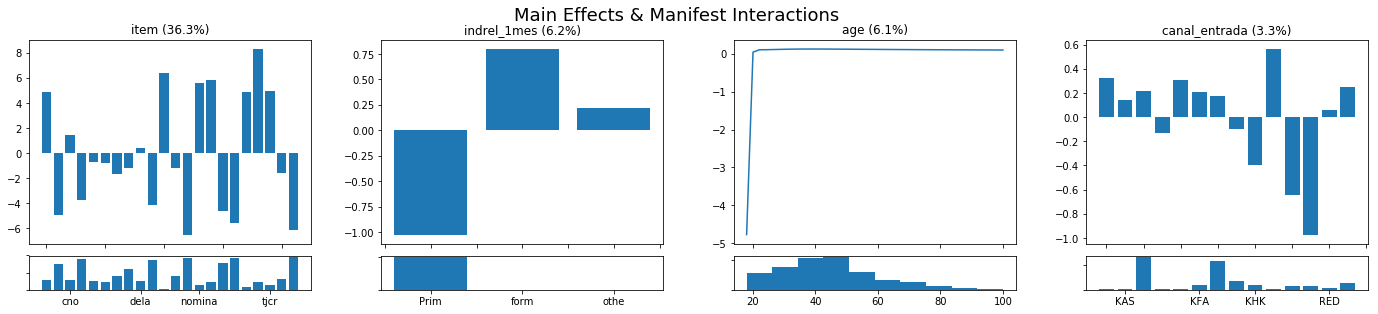

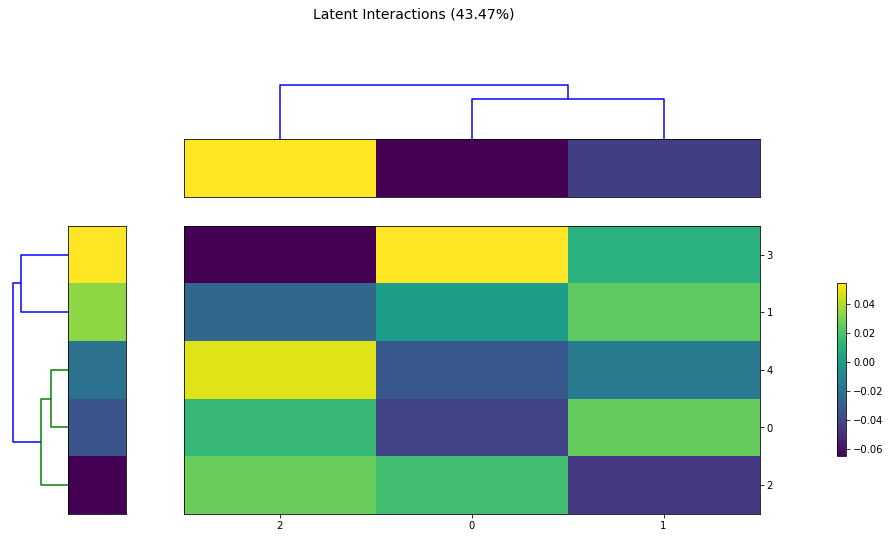

In [5]:
importance = model.get_all_rank(tr_Xi)
model.dash_board(data_dict, importance,simu_dir,True)

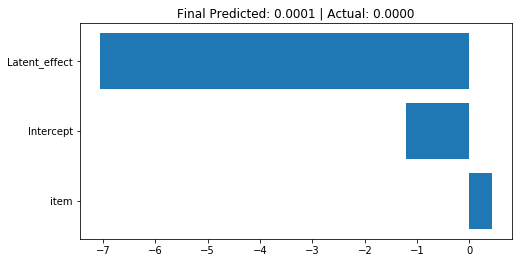

In [6]:
data_dict_local = model.local_explain(0,21,tr_x,tr_Xi,tr_y)
local_visualize(data_dict_local, save_eps=True, folder=simu_dir, name='s1_local',task_type='Classification')

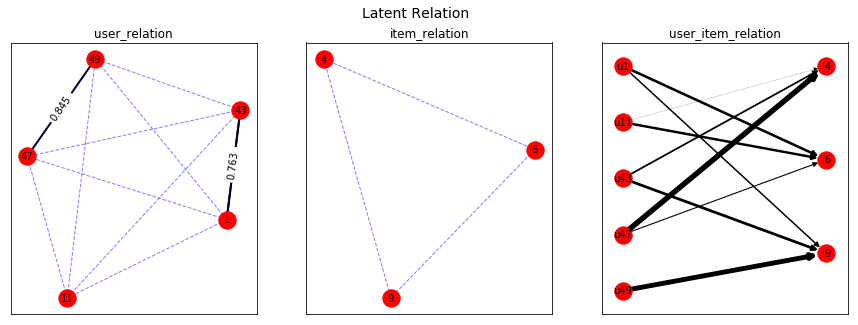

In [7]:
model.relation_plot(0.7,100,True)

kid group: [40, 37, 18, 25, 9]
contain users: 19363
mean : [ 6.28573079e-05 -1.10881856e-04 -6.67764233e-05]
std : [0.00245554 0.0052398  0.00491043]


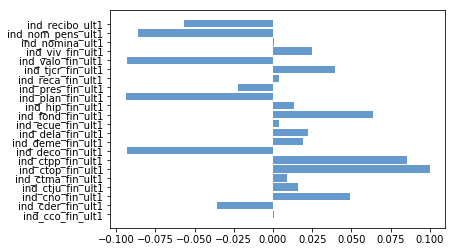

In [15]:
model.group_explain(48,'user')

kid group: [47]
contain users: 1248
mean : [-6.41301657e-05  1.19754063e-04 -1.62768596e-04]
std : [0.00243039 0.00514925 0.00466471]


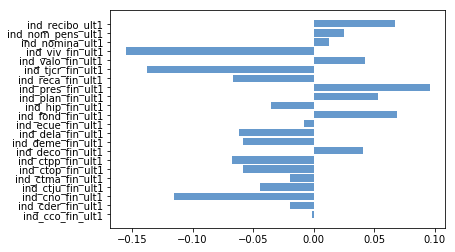

In [16]:
model.group_explain(38,'user')

In [17]:
new = te_x[14,:].reshape(1,-1)
_ = model.cold_start_analysis(new,'user',1.96)

The new user belong to group 43
 mean is [ 1.05713072e-04  1.22829871e-05 -4.09393333e-05]
 and std is [0.00258646 0.00523634 0.00479674]
 the confidence interval is [[-0.00496376 -0.01025095 -0.00944255],[0.00517518 0.01027552 0.00936067]]
